In [1]:
import os
print(os.listdir("../input"))
print(os.listdir("../input/datadev"))

['datadev']
['data-dev']


## Import fastai

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import sys
print ("Python version:", sys.version)

Python version: 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]


In [4]:
from pathlib import Path

In [5]:
#root_p = Path('..\data-dev')   #local pc (cpu)
root_p = Path('../input/datadev/data-dev') #kaggle gpu
root_p.exists()

True

## Create Databunch
1. How to split the data into a training and validation sets?
2. How to split the data into a training and validation sets?
3. How to label the inputs?
4. What transforms to apply?
5. How to add a test set? (optional)
6. How to wrap in dataloaders and create the DataBunch?

In [6]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=5.0, max_zoom=1.1, max_lighting=0.4, max_warp=0.20, p_affine=0.75, p_lighting=0.75)

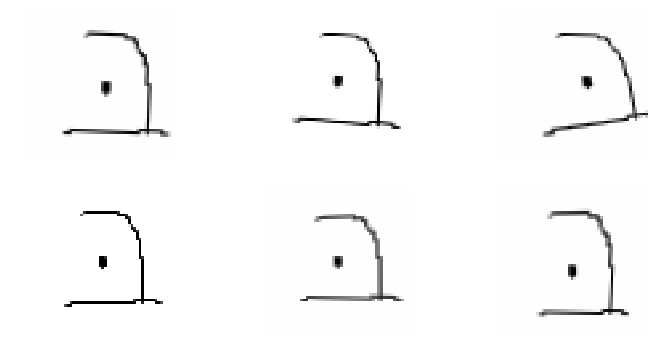

In [7]:
def get_ex(): return open_image('../input/datadev/data-dev/bet-2/bet-1.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
    
plots_f(2, 3, 12, 6, size=(56,56))

In [8]:
data = (ImageList.from_folder(root_p) #Where are the inputs and how to create them?
        .split_by_rand_pct(seed=1)    #How to split the data into a training and validation sets?
        .label_from_folder()
        .transform(tfms, size=(56,56))
        .databunch(bs=8))

data

ImageDataBunch;

Train: LabelList (96 items)
x: ImageList
Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56)
y: CategoryList
he-6,he-6,he-6,he-6,he-6
Path: ../input/datadev/data-dev;

Valid: LabelList (24 items)
x: ImageList
Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56)
y: CategoryList
dalet-5,vet-3,vet-3,bet-2,alef-1
Path: ../input/datadev/data-dev;

Test: None

In [9]:
data.c, len(data.train_ds), len(data.valid_ds)

(6, 96, 24)

In [10]:
data.classes

['alef-1', 'bet-2', 'dalet-5', 'gimel-4', 'he-6', 'vet-3']

### Show data

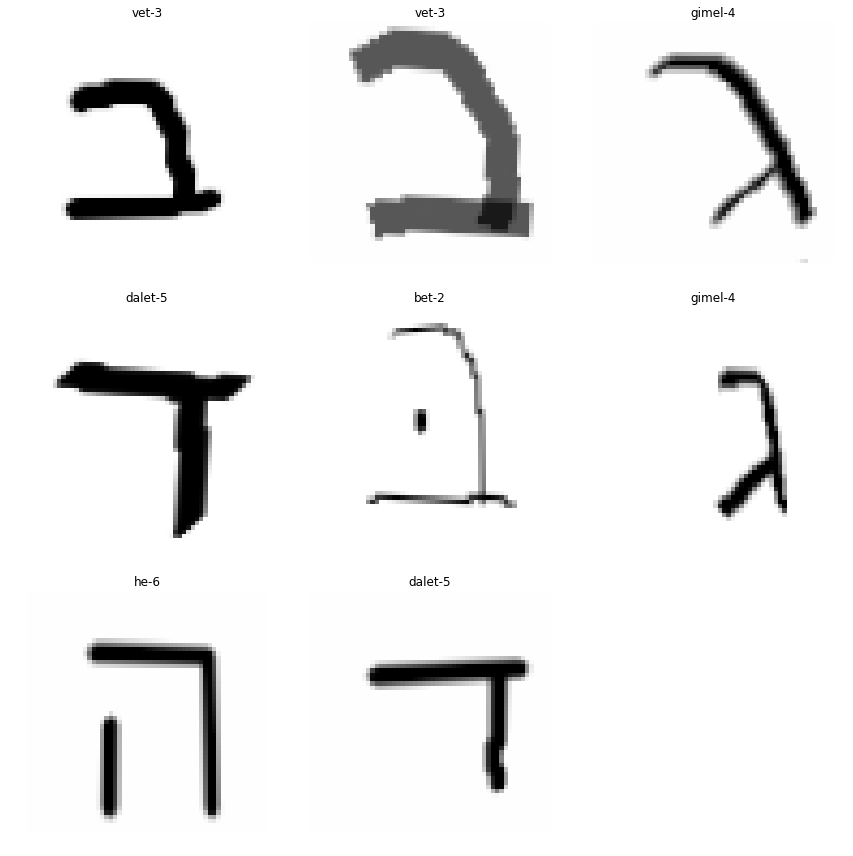

In [11]:
data.show_batch()

## Train model

In [12]:
TMP_PATH = "."
MODEL_PATH = "model/"

#acc_05 = partial(accuracy_thresh, thresh=0.5)
#f1_score = partial(fbeta, beta=1, thresh=0.5)
#learner = cnn_learner(data, models.resnet18, path=TMP_PATH, model_dir=MODEL_PATH, metrics=[acc_05, f1_score])
learner = cnn_learner(data, models.resnet18, path=TMP_PATH, model_dir=MODEL_PATH, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 14.1MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


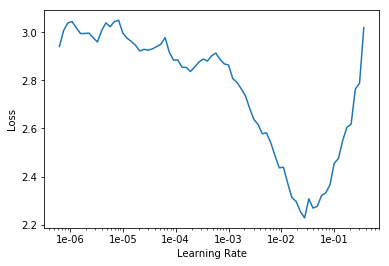

In [13]:
learner.lr_find()
learner.recorder.plot()

In [14]:
lr = 1e-2
learner.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.430837,1.537423,0.416667,00:00
1,1.762815,1.255354,0.666667,00:00
2,1.529377,2.891203,0.458333,00:00
3,1.349033,3.048666,0.541667,00:00
4,1.264969,2.462472,0.541667,00:00
5,1.124521,1.564091,0.708333,00:00
6,1.047889,0.496085,0.833333,00:00
7,1.093319,0.573921,0.833333,00:00
8,0.999561,0.569247,0.875000,00:00
9,0.951866,0.644181,0.916667,00:00


### Save model v1.1

In [15]:
learner.save('rn18-5ep-st1-56x56') #resnet18, 5epochs, stage1, 56x56 image size

### Unfreeze and get ready for finetuning.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


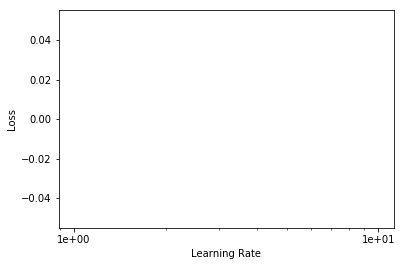

In [16]:
learner.load('rn18-5ep-st1-56x56')
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

### Finetuning (training)

In [17]:
learner.fit_one_cycle(10, slice(1e-3, lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.558205,0.513922,0.875000,00:01
1,1.162441,1.632726,0.458333,00:00
2,1.345900,1.347294,0.583333,00:00
3,1.491143,2.364126,0.750000,00:00
4,1.538990,0.060365,0.958333,00:01
5,1.545870,0.246505,0.958333,00:01
6,1.314680,0.000982,1.000000,00:01
7,1.123386,0.000916,1.000000,00:00
8,0.916079,0.000806,1.000000,00:00
9,0.905434,0.000444,1.000000,00:00


### Save model v1.2

In [18]:
learner.save('rn18-10ep-st2-56x56') #resnet18, 5epochs, stage1, 56x56 image size

## Show results

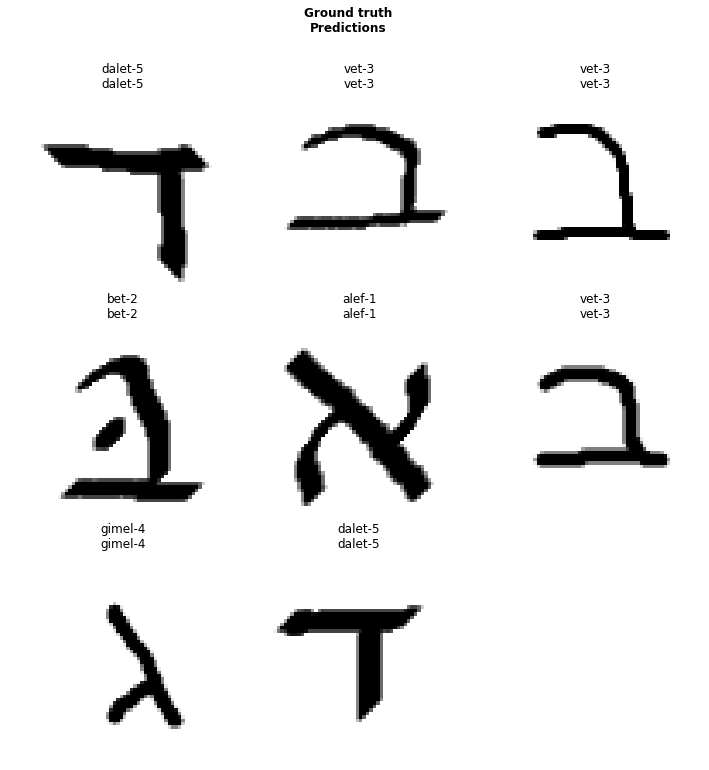

In [19]:
learner.show_results()

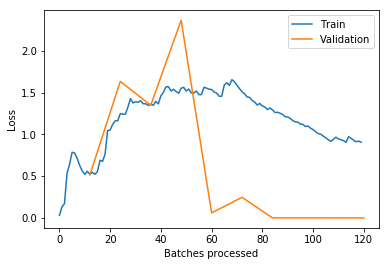

In [20]:
learner.recorder.plot_losses()

## Export model (so we can use the model for inference in another app)

In [21]:
learner.export()